In [1]:
#크롤러를 만들기 전, 필요한 도구들을 import 함
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
#수집을 원하는 카테고리 코드들을 저장한 리스트를 만들어둡니다.ㅡ
idx2word= {'101':'경제', '102':'사회', '103':'생활/문화', '105':'IT/과학'}
code_list = [102, 103, 105]
code_list


[102, 103, 105]

In [3]:
#이전에 생성한 함수들 불러오기
#페이지 수, 카테고리, 날짜를 입력 값으로 받음
def make_urllist(page_num, code, date):
    urllist = []
    for i in range(1, page_num + 1):
        url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=' + str(code) + '&date=' + str(date) + '&page=' + str(i)
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
        news = requests.get(url, headers=headers)
        
        #BeautifulSoup의 인스턴스 생성, 파서는 html.parser 사용
        soup = BeautifulSoup(news.content, 'html.parser')
        
        #case 1 
        news_list = soup.select('.newsflash_body .type06_headline li dl')
        
        #case2
        news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
        
        # 각 뉴스로부터 a 태그인 <a href = '주소'> 에서 '주소'만 가져오기
        
        for line in news_list:
            urllist.append(line.a.get('href'))
            
    return urllist


In [4]:
from newspaper import Article

# 데이터 프레임 생성 함수 
def make_data(urllist, code):
    text_list = []
    for url in urllist:
        article = Article(url, language='ko')
        article.download()
        article.parse()
        text_list.append(article.title)
        
    #데이터 프레임의 'news'키 아래 파싱한 텍스트를 벨류로 붙여준다.
    df = pd.DataFrame({'news': text_list})
    
    # 데이터 프레임의 'code' 키 아래 한글 카테고리명을 붙여준다.
    df['code'] = idx2word[str(code)]
    
    return df

In [5]:
def make_total_data(page_num, code_list, date):
    df = None
    
    for code in code_list:
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code)
        print(str(code) + '번 코드에 대한 데이터를 만들었습니다.')
        
        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            
    return df

In [7]:
import pandas as pd

csv_path = os.getenv("HOME") + "/aiffel/merged_file.csv"
df = pd.read_table(csv_path, sep=',')
df.info()
df.head()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    1086 non-null   object
 1   code    1086 non-null   object
dtypes: object(2)
memory usage: 17.1+ KB


news    object
code    object
dtype: object

In [8]:
#정규 표현식을 이용해 한글 외의 문자는 전부 제거함

df['news'] = df['news'].str.replace("^ㄱ-ㅎㅏ-ㅣ가-힣", "")
#숫자를 제거해도 될까??;;; 

df['news']

/tmp/ipykernel_338/1027656299.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("^ㄱ-ㅎㅏ-ㅣ가-힣", "")


0                        포스코 효자아트홀, 겨울방학 특선 영화 상영
1              "신혼집 집들이서 친구들과 전여친 흉본 남편, 이혼 고민된다"
2            "목숨 끊어져도 무죄"라던 '딸 친구 성폭행' 통학차 기사의 최후
3                             고령군, 지역내 총생산 증가율 1위
4              생때같은 자식 살해·암매장한 ‘비정한 엄마들’…잇단 중형 선고
                          ...                    
1081    "정유사, SAF 생산 근거 마련됐다"...상용화 핵심은 경제성·수요 확대
1082                       펄어비스, CES에서 붉은사막 영상 시연
1083                우주개발 경쟁이 촉발한 로켓 발사, 오존층 파괴 우려
1084          넷마블, 공식 틱톡 팔로워 100만명 돌파…'실버 어워드' 수상
1085         ‘페이커’ 이상혁 “모든 대회 우승이 목표…값진 한 해 만들 것”
Name: news, Length: 1086, dtype: object

In [9]:
print(df.isnull().sum())

news    0
code    0
dtype: int64


In [10]:
#중복 샘플 제거 

df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수 :', len(df))


뉴스 기사의 개수 : 1086


<AxesSubplot:>

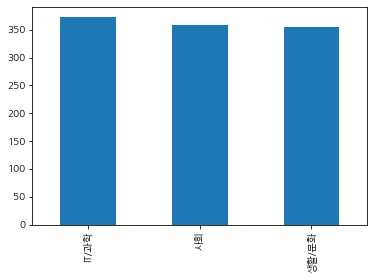

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [12]:
print(df.groupby('code').size().reset_index(name='count'))

    code  count
0  IT/과학    372
1     사회    359
2  생활/문화    355


In [13]:
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'


In [14]:
#형태소 분석, = 즉 토큰화 (tokenization)
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [15]:
stopwords = ['가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공동으로', '과', '과연', '관계가 있다', '관계없이', '관련이 있다', '관하여', '관한', '관해서는', '구', '구체적으로', '구토하다', '그', '그들', '그때', '그래', '그래도', '그래서', '그러나', '그러니', '그러니까', '그러면', '그러므로', '그러한즉', '그런 까닭에', '그런데', '그런즉', '그럼', '그럼에도 불구하고', '그렇게 함으로써', '그렇지', '그렇지 않다면', '그렇지 않으면', '그렇지만', '그렇지않으면', '그리고', '그리하여', '그만이다', '그에 따르는', '그위에', '그저', '그중에서', '그치지 않다', '근거로', '근거하여', '기대여', '기점으로', '기준으로', '기타', '까닭으로', '까악', '까지', '까지 미치다', '까지도', '꽈당', '끙끙', '끼익', '나', '나머지는', '남들', '남짓', '너', '너희', '너희들', '네', '넷', '년', '논하지 않다', '놀라다', '누가 알겠는가', '누구', '다른', '다른 방면으로', '다만', '다섯', '다소', '다수', '다시 말하자면', '다시말하면', '다음', '다음에', '다음으로', '단지', '답다', '당신', '당장', '대로 하다', '대하면', '대하여', '대해 말하자면', '대해서', '댕그', '더구나', '더군다나', '더라도', '더불어', '더욱더', '더욱이는', '도달하다', '도착하다', '동시에', '동안', '된바에야', '된이상', '두번째로', '둘', '둥둥', '뒤따라', '뒤이어', '든간에', '들', '등', '등등', '딩동', '따라', '따라서', '따위', '따지지 않다', '딱', '때', '때가 되어', '때문에', '또', '또한', '뚝뚝', '라 해도', '령', '로', '로 인하여', '로부터', '로써', '륙', '를', '마음대로', '마저', '마저도', '마치', '막론하고', '만 못하다', '만약', '만약에', '만은 아니다', '만이 아니다', '만일', '만큼', '말하자면', '말할것도 없고', '매', '매번', '메쓰겁다', '몇', '모', '모두', '무렵', '무릎쓰고', '무슨', '무엇', '무엇때문에', '물론', '및', '바꾸어말하면', '바꾸어말하자면', '바꾸어서 말하면', '바꾸어서 한다면', '바꿔 말하면', '바로', '바와같이', '밖에 안된다', '반대로', '반대로 말하자면', '반드시', '버금', '보는데서', '보다더', '보드득', '본대로', '봐', '봐라', '부류의 사람들', '부터', '불구하고', '불문하고', '붕붕', '비걱거리다', '비교적', '비길수 없다', '비로소', '비록', '비슷하다', '비추어 보아', '비하면', '뿐만 아니라', '뿐만아니라', '뿐이다', '삐걱', '삐걱거리다', '사', '삼', '상대적으로 말하자면', '생각한대로', '설령', '설마', '설사', '셋', '소생', '소인', '솨', '쉿', '습니까', '습니다', '시각', '시간', '시작하여', '시초에', '시키다', '실로', '심지어', '아', '아니', '아니나다를가', '아니라면', '아니면', '아니었다면', '아래윗', '아무거나', '아무도', '아야', '아울러', '아이', '아이고', '아이구', '아이야', '아이쿠', '아하', '아홉', '안 그러면', '않기 위하여', '않기 위해서', '알 수 있다', '알았어', '앗', '앞에서', '앞의것', '야', '약간', '양자', '어', '어기여차', '어느', '어느 년도', '어느것', '어느곳', '어느때', '어느쪽', '어느해', '어디', '어때', '어떠한', '어떤', '어떤것', '어떤것들', '어떻게', '어떻해', '어이', '어째서', '어쨋든', '어쩔수 없다', '어찌', '어찌됏든', '어찌됏어', '어찌하든지', '어찌하여', '언제', '언젠가', '얼마', '얼마 안 되는 것', '얼마간', '얼마나', '얼마든지', '얼마만큼', '얼마큼', '엉엉', '에', '에 가서', '에 달려 있다', '에 대해', '에 있다', '에 한하다', '에게', '에서', '여', '여기', '여덟', '여러분', '여보시오', '여부', '여섯', '여전히', '여차', '연관되다', '연이서', '영', '영차', '옆사람', '예', '예를 들면', '예를 들자면', '예컨대', '예하면', '오', '오로지', '오르다', '오자마자', '오직', '오호', '오히려', '와', '와 같은 사람들', '와르르', '와아', '왜', '왜냐하면', '외에도', '요만큼', '요만한 것', '요만한걸', '요컨대', '우르르', '우리', '우리들', '우선', '우에 종합한것과같이', '운운', '월', '위에서 서술한바와같이', '위하여', '위해서', '윙윙', '육', '으로', '으로 인하여', '으로서', '으로써', '을', '응', '응당', '의', '의거하여', '의지하여', '의해', '의해되다', '의해서', '이', '이 되다', '이 때문에', '이 밖에', '이 외에', '이 정도의', '이것', '이곳', '이때', '이라면', '이래', '이러이러하다', '이러한', '이런', '이럴정도로', '이렇게 많은 것', '이렇게되면', '이렇게말하자면', '이렇구나', '이로 인하여', '이르기까지', '이리하여', '이만큼', '이번', '이봐', '이상', '이어서', '이었다', '이와 같다', '이와 같은', '이와 반대로', '이와같다면', '이외에도', '이용하여', '이유만으로', '이젠', '이지만', '이쪽', '이천구', '이천육', '이천칠', '이천팔', '인 듯하다', '인젠', '일', '일것이다', '일곱', '일단', '일때', '일반적으로', '일지라도', '임에 틀림없다', '입각하여', '입장에서', '잇따라', '있다', '자', '자기', '자기집', '자마자', '자신', '잠깐', '잠시', '저', '저것', '저것만큼', '저기', '저쪽', '저희', '전부', '전자', '전후', '점에서 보아', '정도에 이르다', '제', '제각기', '제외하고', '조금', '조차', '조차도', '졸졸', '좀', '좋아', '좍좍', '주룩주룩', '주저하지 않고', '줄은 몰랏다', '줄은모른다', '중에서', '중의하나', '즈음하여', '즉', '즉시', '지든지', '지만', '지말고', '진짜로', '쪽으로', '차라리', '참', '참나', '첫번째로', '쳇', '총적으로', '총적으로 말하면', '총적으로 보면', '칠', '콸콸', '쾅쾅', '쿵', '타다', '타인', '탕탕', '토하다', '통하여', '툭', '퉤', '틈타', '팍', '팔', '퍽', '펄렁', '하', '하게될것이다', '하게하다', '하겠는가', '하고 있다', '하고있었다', '하곤하였다', '하구나', '하기 때문에', '하기 위하여', '하기는한데', '하기만 하면', '하기보다는', '하기에', '하나', '하느니', '하는 김에', '하는 편이 낫다', '하는것도', '하는것만 못하다', '하는것이 낫다', '하는바', '하더라도', '하도다', '하도록시키다', '하도록하다', '하든지', '하려고하다', '하마터면', '하면 할수록', '하면된다', '하면서', '하물며', '하여금', '하여야', '하자마자', '하지 않는다면', '하지 않도록', '하지마', '하지마라', '하지만', '하하', '한 까닭에', '한 이유는', '한 후', '한다면', '한다면 몰라도', '한데', '한마디', '한적이있다', '한켠으로는', '한항목', '할 따름이다', '할 생각이다', '할 줄 안다', '할 지경이다', '할 힘이 있다', '할때', '할만하다', '할망정', '할뿐', '할수있다', '할수있어', '할줄알다', '할지라도', '할지언정', '함께', '해도된다', '해도좋다', '해봐요', '해서는 안된다', '해야한다', '해요', '했어요', '향하다', '향하여', '향해서', '허', '허걱', '허허', '헉', '헉헉', '헐떡헐떡', '형식으로 쓰여', '혹시', '혹은', '혼자', '훨씬', '휘익', '휴', '흐흐', '흥', '힘입어']

In [16]:
def preprocessing(data):
    text_data = []
    
    for sentence in data:
        temp_data = []
        #토큰화 
        temp_data = tokenizer.morphs(sentence)
        
        #불용어 제거
        temp_data = [word for word in temp_data if not word in stopwords]
        text_data.append(temp_data)
        
    text_data = list(map(''.join, text_data))
    
    return text_data
        
    

In [17]:
text_data = preprocessing(df['news'])
print(text_data[0])

포스코효자아트홀,겨울방학특선영화상영


In [18]:
def preprocessing(data):
    text_data = []

    for index, sentence in enumerate(data):
        try:
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(' '.join(temp_data))
        except Exception as e:
            print(f"Error at index {index}: {sentence}\nError: {e}")
            text_data.append('')  # Append an empty string or some placeholder
            continue  # Continue with the next iteration

    return text_data

print(len(text_data))

1086


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [20]:
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state =0)

In [21]:
#분리된 데이터의 갯수 확인
print('훈련용 뉴스 기사의 갯수 :', len(X_train))
print('테스트용 뉴스 기사의 갯수:', len(X_test))
print('훈련용 레이블의 갯수 :', len(y_train))
print('테스트용 레이블의 갯수:', len(y_test))

훈련용 뉴스 기사의 갯수 : 814
테스트용 뉴스 기사의 갯수: 272
훈련용 레이블의 갯수 : 814
테스트용 레이블의 갯수: 272


In [22]:
#단어의 수를 카운트하는 사이킷런의 카운트벡터라이저
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻음
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#나이브 베이즈 분류기를 수행 
#X_train은 TF-IDF 벡터, y_train은 레이블
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [23]:
def tfidf_vectorizer(data):
    data_counts = count_vect.transform(data)
    data_tfidf = tfidf_transformer.transform(data_counts)
    return data_tfidf

In [24]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])


print(clf.predict(tfidf_vectorizer(new_sent)))

['생활/문화']


In [25]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

['사회']


In [26]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['IT/과학']


In [27]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.79      0.31      0.44        97
          사회       0.38      0.95      0.54        82
       생활/문화       0.86      0.26      0.40        93

    accuracy                           0.49       272
   macro avg       0.68      0.51      0.46       272
weighted avg       0.69      0.49      0.46       272



In [ ]:
#이지현 회고 : 저는 왜 70%대가 안나올까요? 머신러닝도 뽑기 운이 있나봅니다..